In [1]:
import zipfile
import joblib
import yaml
import io
from pathlib import Path

class ScalingZipLoader:
    def __init__(self, zip_path):
        self.zip_path = Path(zip_path)
        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ไม่พบไฟล์ ZIP: {zip_path}")

        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

    def load(self):
        """โหลด input/output scaler และ metadata จาก ZIP"""
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            # ✅ โหลด input_scaler.pkl
            with zipf.open("input_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_in = joblib.load(buffer)

            # ✅ โหลด output_scaler.pkl
            with zipf.open("output_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_out = joblib.load(buffer)

            # ✅ โหลด metadata.yaml
            with zipf.open("metadata.yaml") as f:
                self.metadata = yaml.safe_load(f)

        print(f"📦 Loaded ZIP successfully: {self.zip_path}")
        return self.scaler_in, self.scaler_out, self.metadata


if __name__ == "__main__":
    # 🧪 ตัวอย่างการใช้งาน
    zip_file = r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip"
    loader = ScalingZipLoader(zip_file)
    scaler_in, scaler_out, metadata = loader.load()

    print("\n🎯 Metadata summary:")
    print(yaml.dump(metadata, allow_unicode=True, sort_keys=False))

    # ✅ ตัวอย่างการใช้งาน scaler
    import numpy as np
    sample_input = np.array([[0.5]])
    scaled_input = scaler_in.transform(sample_input)
    print("\nSample input 0.5 scaled:", scaled_input)


📦 Loaded ZIP successfully: D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip

🎯 Metadata summary:
dataset_name: RC_Tank_Env_Training2
scaler_type: MinMaxScaler
num_files: 50
input_features:
- DATA_INPUT
output_features:
- DATA_OUTPUT
input_min:
- 0.0
input_max:
- 24.0
output_min:
- 0.08
output_max:
- 23.998895762088527


Sample input 0.5 scaled: [[0.02083333]]


Epoch 1/50, Loss: 0.139507
Epoch 5/50, Loss: 0.051848
Epoch 10/50, Loss: 0.012823
Epoch 15/50, Loss: 0.004715
Epoch 20/50, Loss: 0.001939
Epoch 25/50, Loss: 0.000816
Epoch 30/50, Loss: 0.000333
Epoch 35/50, Loss: 0.000204
Epoch 40/50, Loss: 0.000167
Epoch 45/50, Loss: 0.000149
Epoch 50/50, Loss: 0.000129


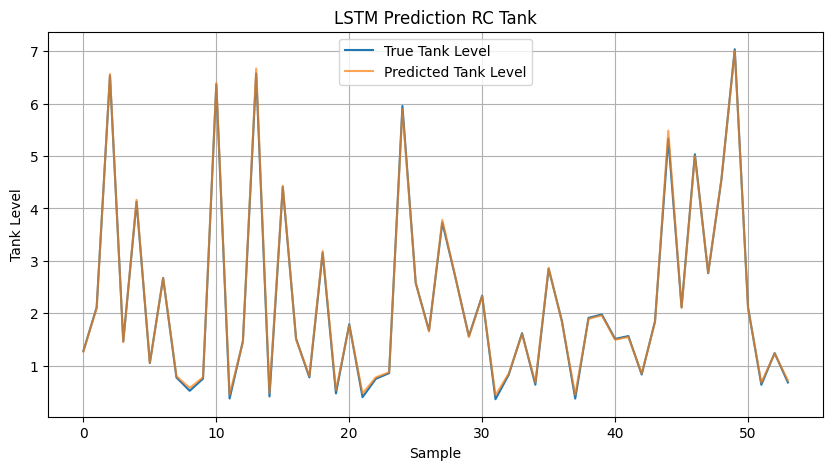

In [3]:
# -----------------------------
# LSTM RC Tank Prediction Example
# -----------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# -----------------------------
# Load dataset
# -----------------------------
data_file = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.10_freq_0.10_pwm.csv"
df = pd.read_csv(data_file)

# -----------------------------
# Load scalers (จาก ZIP ก็ได้)
# -----------------------------
# ตัวอย่างใช้ MinMaxScaler ใหม่
input_features = ["DATA_INPUT", "DATA_OUTPUT"]
output_features = ["DATA_OUTPUT"]

scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

X_scaled = scaler_in.fit_transform(df[input_features].values)
y_scaled = scaler_out.fit_transform(df[output_features].values)

# -----------------------------
# สร้าง sequences สำหรับ LSTM
# -----------------------------
window_size = 30

def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size=window_size)

# แบ่ง train/val/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# แปลงเป็น torch.Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# -----------------------------
# สร้าง LSTM model
# -----------------------------
class LSTM_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

model = LSTM_Predictor(input_size=input_size, hidden_size=64, num_layers=2, output_size=output_size)

# -----------------------------
# Training setup
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
batch_size = 64

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= X_train.size(0)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

# -----------------------------
# Test & Plot
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# แปลงกลับ scale เดิม
y_pred_orig = scaler_out.inverse_transform(y_pred)
y_test_orig = scaler_out.inverse_transform(y_test.numpy())

plt.figure(figsize=(10,5))
plt.plot(y_test_orig, label="True Tank Level")
plt.plot(y_pred_orig, label="Predicted Tank Level", alpha=0.7)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Tank Level")
plt.title("LSTM Prediction RC Tank")
plt.grid(True)
plt.show()


In [8]:
import sys
from pathlib import Path

# project_root = my_project
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("✅ Project root added to sys.path:", project_root)

✅ Project root added to sys.path: D:\Project_end\New_world\my_project


In [10]:
import src.models.lstm_model
print(dir(src.models.lstm_model))

['LSTMForecaster', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'torch']


In [ ]:
%run setup_path.py

import torch
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
import matplotlib.pyplot as plt
from pathlib import Path

File_scale = Path(r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip")
loader = ScalingZipLoader(File_scale)

x = loader.transform_input


AttributeError: 'ScalingZipLoader' object has no attribute 'load_scaled_data'